#  Parte 2

El objetivo de este entregable es calibrar un modelo ARIMA-SARIMA para la serie del ÍNDICE GLOBAL DE ACTIVIDAD ECONÓMICA de México. Se realizará el proceso de manejo de datos y calibración del modelo para obtener un pronóstico de la economía mexicana hasta el cierre del sexenio actual (SEP 2024).

Lectura de datos

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/MyDrive/IA/Estadistica"
%ls

/content/gdrive/MyDrive/IA/Estadistica
bcase.html   Datos.csv         Entregable2.ipynb     Firmas.csv
bcase.ipynb  Entregable2.html  Entregable2Pt2.ipynb  Indicadores.csv


Importación de librerias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

In [ ]:
df_ind = pd.read_csv('Indicadores.csv')


In [ ]:
df_ind

,Periodo,Valor
0,2022/07,111.274552
1,2022/06,112.797501
2,2022/05,114.442424
3,2022/04,109.529866
4,2022/03,111.940152
...,...,...
350,1993/05,63.612900
351,1993/04,61.865984
352,1993/03,63.943249
353,1993/02,61.022521


Ordenamiento de los datos

In [ ]:
df_ind = df_ind.sort_values(by='Periodo')
df_ind = df_ind.reset_index(drop=True)

In [ ]:
df_ind

,Periodo,Valor
0,1993/01,60.407691
1,1993/02,61.022521
2,1993/03,63.943249
3,1993/04,61.865984
4,1993/05,63.612900
...,...,...
350,2022/03,111.940152
351,2022/04,109.529866
352,2022/05,114.442424
353,2022/06,112.797501


**Converción a estacionario**

**Definición de D y d**

Procederemos a ver si nuestros datos ya son estacionarios

In [ ]:
df_ind['lny'] = np.log(df_ind['Valor'])

In [ ]:
from statsmodels.tsa.stattools import adfuller
d_test = adfuller(df_ind['lny'])
print('p-value: %f' % d_test[1])

p-value: 0.669224


Recordemos que el p-value debe de tener un valor menor a 0.05 para poder determinar que nuestra variable ya es estacionaria, por ello podemos saber que nuestra variable de momento no es estacionaria, ya que su valor esta muy alejado del 0.05

Se recomienda siempre iniciar con el valor de D = 1 en donde se resta el valor original menos el valor 12 registros atrás

In [ ]:
df_ind['G']= df_ind['lny']  - np.log(df_ind['Valor']).shift(12)
df_ind

,Periodo,Valor,lny,G
0,1993/01,60.407691,4.101116,NaN
1,1993/02,61.022521,4.111243,NaN
2,1993/03,63.943249,4.157996,NaN
3,1993/04,61.865984,4.124970,NaN
4,1993/05,63.612900,4.152816,NaN
...,...,...,...,...
350,2022/03,111.940152,4.717964,0.003661
351,2022/04,109.529866,4.696197,0.013414
352,2022/05,114.442424,4.740072,0.021001
353,2022/06,112.797501,4.725594,0.014522


Debido a que para los siguientes procesos ocupamos que no haya valores nulos, tendremos 2 datasets, uno con todos los registros y otro donde los registros no tengan ningun na

In [ ]:
df_vanilla = df_ind.copy()

In [ ]:
df_ind = df_ind.dropna()

In [ ]:
from statsmodels.tsa.stattools import adfuller
d_test = adfuller(df_ind['G'])
print('p-value: %f' % d_test[1])

p-value: 0.003260


Como podemos observar el p-value de nuestra variable es menor a 0.05, esto nos dice que con un valor de D = 1 y d = 0, nuestra variable ya es estacionaria.

Viendo que con un lag de 12 la variable se vuelve estacionaria le asignamos un valore de D = 1, d = 0 para nuestro modelo

In [ ]:
D = 1
d = 0

**Definición de p y q**

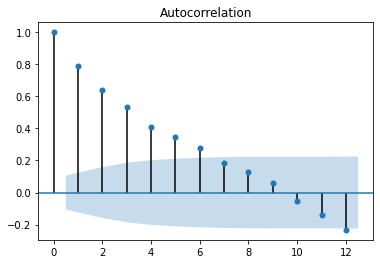

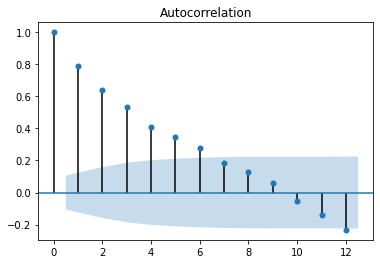

In [ ]:
plot_acf(df_ind.G, lags = 12)

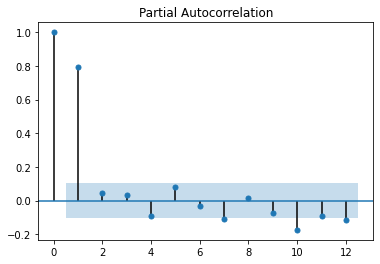

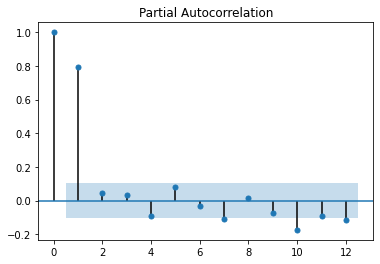

In [ ]:
plot_pacf(df_ind.G, lags = 12)

Podemos observar que solo hay una relación que es significativa, que es el registro anterior respecto a cada registro de la variable.

Al ver esta tendencia de autocorrelación con un solo valor, se asigna el valor de 1 a p

Se asignaran los valores de p = 1, q = 0

In [ ]:
p = 1
q = 0

# Primer Modelo SARIMA(p = 1, d = 0 , q =0) (P = 0, D = 1, Q = 0)


In [ ]:
P = 0
Q = 0

In [ ]:
import statsmodels.api as sm

In [ ]:
m1 = sm.tsa.statespace.SARIMAX(df_vanilla['lny'], order=(p,d,q), seasonal_order = (P,D,Q,12), trend='c',  simple_differencing=True)

In [ ]:
m1_res = m1.fit(disp = 0)

In [ ]:
print(m1_res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           DS12.lny   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 741.706
Date:                            Tue, 25 Oct 2022   AIC                          -1477.413
Time:                                    01:25:52   BIC                          -1465.899
Sample:                                         0   HQIC                         -1472.827
                                            - 343                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.741      0.006       0.001       0.007
ar.L1          0.7905      0.021   

Hemos terminado el primer modelo, podemos ver que el lag1 es bastante signifativo para el modelo, con un p-value menor a 0.05 y con una magnitud de 0.7905, además vemos que el intercepto tiene un valor de 0.0041.

Ahora ya teniendo nuestro primer modelo, vamos a ver los errores y como estos se comportan, por ello volveremos a visualizar los gráficos de ACF y PACF pero esta vez aplicados al error.

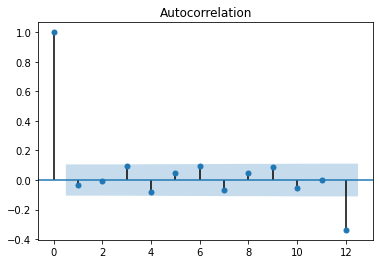

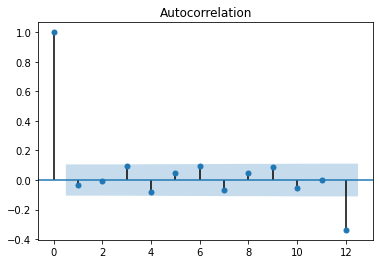

In [ ]:
plot_acf(m1_res.resid, lags = 12)

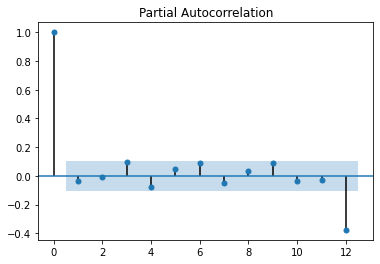

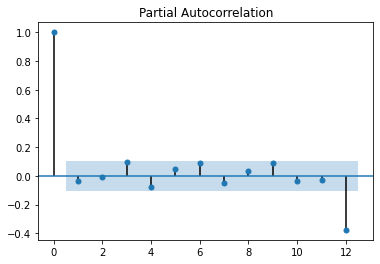

In [ ]:
plot_pacf(m1_res.resid, lags = 12)

Observamos que hay una fuerte autocorrelación negativa en el lag 12, al ver este tipo de patrones se asigna un valor de 1 a Q.

Dado lo anterior crearemos un nuevo modelo


# Segundo Modelo SARIMA(p = 1, d = 0 , q =0) (P = 0, D = 1, Q = 1)


In [ ]:
Q = 1

In [ ]:
m2 = sm.tsa.statespace.SARIMAX(df_vanilla['lny'], order=(p,d,q), seasonal_order = (P,D,Q,12),  trend='c',  simple_differencing=True)

In [ ]:
m2_res = m2.fit()

In [ ]:
print(m2_res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             DS12.lny   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 805.821
Date:                              Tue, 25 Oct 2022   AIC                          -1603.642
Time:                                      01:25:54   BIC                          -1588.291
Sample:                                           0   HQIC                         -1597.528
                                              - 343                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0025      0.000      6.274      0.000       0.002       0.003
ar.L1          0.87

Ahora ya teniendo nuestro segundo modelo, vamos a ver los errores y como estos se comportan, por ello volveremos a visualizar los gráficos de ACF y PACF pero esta vez aplicados al error.

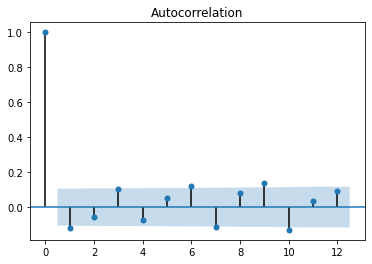

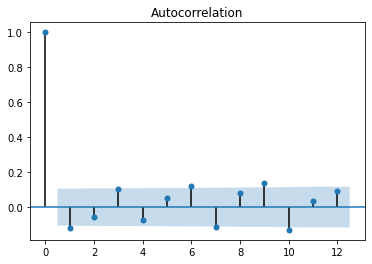

In [ ]:
plot_acf(m2_res.resid, lags = 12)

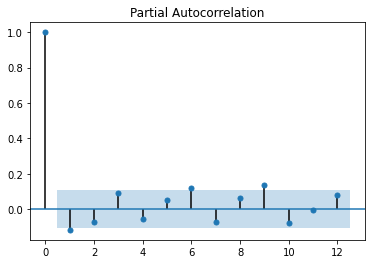

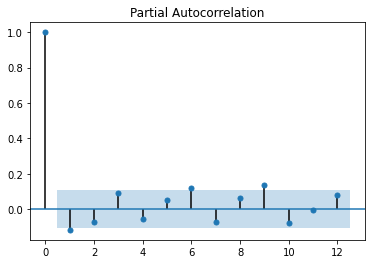

In [ ]:
plot_pacf(m2_res.resid, lags = 12)

El valor del error anterior parece que sobresale por encima del 0.95% de significancia, por ello crearemos un nuevo modelo en donde el valor nuevo de q sera 1

# Tercer Modelo SARIMA(p = 1, d = 0 , q =1) (P = 0, D = 1, Q = 1)


In [ ]:
q = 1

In [ ]:
m3 = sm.tsa.statespace.SARIMAX(df_vanilla['Valor'], order=(p,d,q), seasonal_order = (P,D,Q,12),  trend='c',  simple_differencing=True)

In [ ]:
m3_res = m3.fit()

In [ ]:
print(m3_res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         DS12.Valor   No. Observations:                  343
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -743.398
Date:                            Tue, 25 Oct 2022   AIC                           1496.795
Time:                                    01:25:55   BIC                           1515.984
Sample:                                         0   HQIC                          1504.439
                                            - 343                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2018      0.048      4.187      0.000       0.107       0.296
ar.L1          0.8855      0.026   

Ahora ya teniendo nuestro tercer modelo, vamos a ver los errores y como estos se comportan.

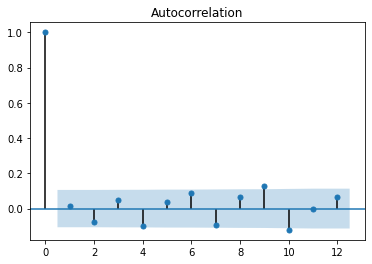

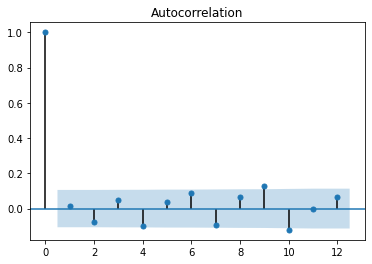

In [ ]:
plot_acf(m3_res.resid, lags = 12)

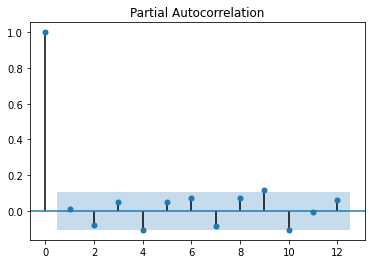

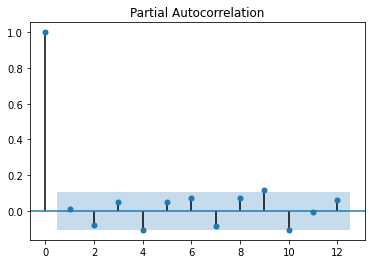

In [ ]:
plot_pacf(m3_res.resid, lags = 12)

Podemos ver que con este tercer modelo se ha logrado practimante un White Noise, lo que nos quiere decir que ya no hay más variables significativas.

Con este modelo final podemos observar que todos los valores asignados al modelo tienen una alta significancia ya que todos tienen un p value menor a 0.05.

Tanto el intercepto como el valor de AR tienen una magnitud postiva con 0.2018 y 0.8855 respectivamente, por el contrario los valores de MA tienen magnitures negativas una con -0.1551 y la otra con -0.8131.

# Predicción

Ahora ya teniendo nuestro modelo podemos hacer predicciones a futuro

In [ ]:
import math

In [ ]:
fm = sm.tsa.statespace.SARIMAX(df_vanilla['Valor'], order=(p,d,q), seasonal_order = (P,D,Q,12),  trend='c')
fm_res = fm.fit()

Vamos  hacer una predicción un año hacia el futuro

In [ ]:
yhat = fm_res.predict(start=0, end=(len(df_vanilla)+27))

In [ ]:
df_vanilla = df_vanilla[['Valor', 'Periodo']]

Se crean los campos para los nuevos años

In [ ]:
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2022/07'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2022/08'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2022/09'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2022/10'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2022/11'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2022/12'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/01'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/02'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/03'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/04'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/05'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/06'], index=['Valor','Periodo']), ignore_index=True)


df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/07'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/08'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/09'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/10'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/11'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2023/12'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/01'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/02'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/03'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/04'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/05'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/06'], index=['Valor','Periodo']), ignore_index=True)

df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/07'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/08'], index=['Valor','Periodo']), ignore_index=True)
df_vanilla = df_vanilla.append(pd.Series([math.nan,'2024/09'], index=['Valor','Periodo']), ignore_index=True)



In [ ]:
df_vanilla['Forecast'] = yhat

In [ ]:
df_vanilla = df_vanilla.reset_index(drop = True)

In [ ]:
df_vanilla = df_vanilla.set_index(['Periodo'], drop=True)

**Predicción historica**

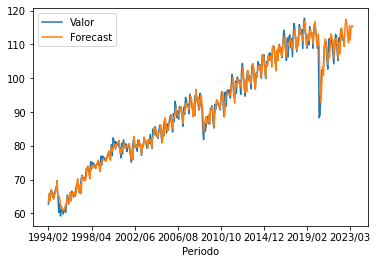

In [ ]:
df_vanilla.iloc[13:367].plot()

**Último año que tenemos más año predecido**

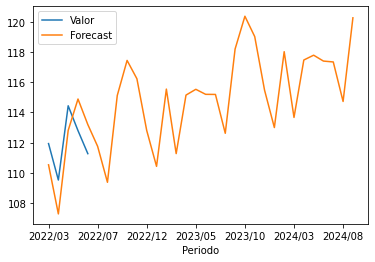

In [ ]:
df_vanilla.iloc[350:382].plot()

In [ ]:
df_vanilla.iloc[350:382]

,Valor,Forecast
Periodo,,
2022/03,111.940152,110.536417
2022/04,109.529866,107.286271
2022/05,114.442424,112.812716
2022/06,112.797501,114.890360
2022/07,111.274552,113.200330
2022/07,NaN,111.758150
2022/08,NaN,109.378845
2022/09,NaN,115.124389
2022/10,NaN,117.445089


Como se ve, hasta el final del sexenio (SEP 2024) sigue comportandose con el patron similar de los años anteriores además de seguir con la tendencia creciente de todos los años, según esta predicción la economia volvera al mismo valor que teniamos a inicios del 2019.

In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/IA/Estadistica/Entregable2Pt2.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/IA/Estadistica/Entregable2Pt2.ipynb to html
[NbConvertApp] Writing 569965 bytes to /content/gdrive/MyDrive/IA/Estadistica/Entregable2Pt2.html
